# Diabetic Retinopathy Classification with Comprehensive Evaluation
Complete Google Colab Implementation

## Step 1: Import Kaggle Dataset and Setup

In [1]:
# IMPORTANT: Run this cell first to import your Kaggle data
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')
print('Data source import complete.')

100%|██████████| 427M/427M [00:10<00:00, 41.3MB/s]

Extracting files...


Data source import complete.


## Step 2: Import All Necessary Libraries

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

# Evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 3: Explore Dataset Structure

In [3]:
# Check available files and structure
print("Dataset structure:")
print("="*50)
for root, dirs, files in os.walk(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path):
    level = root.replace(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Dataset structure:
2/
  train.csv
  gaussian_filtered_images/
    gaussian_filtered_images/
      export.pkl
      No_DR/
        c3789c1dab96.png
        4e4a6224a04e.png
        e9678824215d.png
        1ec95179cdfe.png
        5511f114e7ee.png
        ... and 1800 more files
      Proliferate_DR/
        4bd941611343.png
        95e732e043a1.png
        1c4f3aa4df06.png
        576e189d23d4.png
        02dda30d3acf.png
        ... and 290 more files
      Severe/
        f64214bed40e.png
        3b018e8b7303.png
        91cf56d3d1af.png
        0c917c372572.png
        b019a49787c1.png
        ... and 188 more files
      Moderate/
        842d697884f6.png
        20404ec7b518.png
        000c1434d8d7.png
        20c883d3bd38.png
        b8ac328009e0.png
        ... and 994 more files
      Mild/
        07929d32b5b3.png
        2ecbc2e3f239.png
        ca6842bfcbc9.png
        59e5212f7139.png
        d3de0d313d61.png
        ... and 365 more files


## Step 4: Data Preprocessing and Augmentation

In [4]:
# Data preprocessing with proper augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation data should only be rescaled, no augmentation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Update the data path to the correct location
data_path = os.path.join(sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path, 'gaussian_filtered_images', 'gaussian_filtered_images')

print(f"Data path: {data_path}")
print(f"Path exists: {os.path.exists(data_path)}")

Data path: /root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered/versions/2/gaussian_filtered_images/gaussian_filtered_images
Path exists: True


## Step 5: Create Data Generators

In [5]:
# Create data generators
train_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_data = valid_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Data generators created successfully!")
print("="*50)
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {valid_data.samples}")
print(f"Number of classes: {train_data.num_classes}")
print(f"Class indices: {train_data.class_indices}")

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Data generators created successfully!
Training samples: 2931
Validation samples: 731
Number of classes: 5
Class indices: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


## Step 6: Learning Rate Scheduler and Callbacks

In [6]:
# Improved learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00005

# Create callbacks
lr_callback = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

print("Callbacks configured successfully!")

Callbacks configured successfully!


## Step 7: Model Architecture

In [7]:
# Build improved model with EfficientNetB0
def create_model(num_classes):
    base_model = EfficientNetB0(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = True
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile model
model = create_model(train_data.num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,004,961 (15.28 MB)

 Non-trainable params: 209,223 (817.28 KB)

## Step 8: Train the Model

In [8]:
print("\nStarting model training...")
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[lr_callback, early_stopping, reduce_lr],
    verbose=1
)
print("Training completed!")


Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 844ms/step - accuracy: 0.5141 - loss: 1.2775 - val_accuracy: 0.2722 - val_loss: 1.7300 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.6029 - loss: 1.1178 - val_accuracy: 0.4938 - val_loss: 1.3132 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - accuracy: 0.5857 - loss: 1.1163 - val_accuracy: 0.4938 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 447ms/step - accuracy: 0.6157 - loss: 1.0519 - val_accuracy: 0.4938 - val_loss: 1.1839 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - accuracy: 0.6312 - loss: 1.0168 - val_accuracy: 0.4938 - val_loss: 2.4110 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.6252 - loss: 1.0297 - val_accuracy: 0.4938 - val_loss: 1.3282 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 444ms/step - accuracy: 0.6244 - loss: 1

## Step 9: Plot Training History

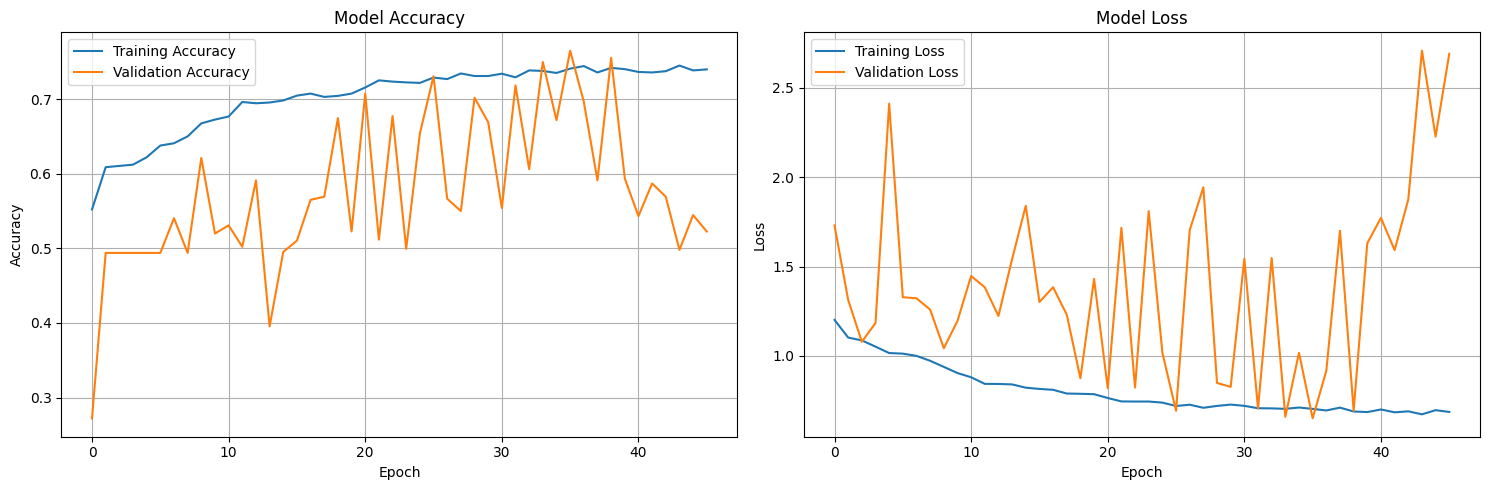

In [19]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)



## Step 10: Advanced Evaluation Metrics

In [20]:
# Function to calculate Quadratic Weighted Kappa Score
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    """
    Calculate Quadratic Weighted Kappa Score
    This is more appropriate for ordinal classification like DR severity levels
    """
    # Create weight matrix
    weights = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            weights[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)

    # Calculate observed and expected matrices
    hist_true = np.bincount(y_true, minlength=num_classes)
    hist_pred = np.bincount(y_pred, minlength=num_classes)

    O = confusion_matrix(y_true, y_pred)
    E = np.outer(hist_true, hist_pred) / len(y_true)

    # Calculate weighted kappa
    numerator = np.sum(weights * O)
    denominator = np.sum(weights * E)

    if denominator == 0:
        return 0.0

    kappa = 1 - (numerator / denominator)
    return kappa

# Function to get predictions and true labels from validation data
def get_predictions_and_labels(model, data_generator):
    """
    Get predictions and true labels from data generator
    """
    # Reset generator
    data_generator.reset()

    # Get predictions
    predictions = model.predict(data_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_labels = data_generator.classes

    return predicted_classes, true_labels, predictions

## Step 11: Comprehensive Evaluation

In [28]:
print("Getting predictions for validation data...")
y_pred, y_true, y_pred_proba = get_predictions_and_labels(model, valid_data)

print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION METRICS")
print("="*60)

# Basic accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Cohen's Kappa Score (standard)
kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

# Quadratic Weighted Kappa Score
qwk_score = quadratic_weighted_kappa(y_true, y_pred, train_data.num_classes)
print(f"Quadratic Weighted Kappa Score: {qwk_score:.4f}")

# Precision, Recall, F1-Score
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# Kappa Score Interpretation
print("\n" + "="*40)
print("KAPPA SCORE INTERPRETATION")
print("="*40)

def interpret_kappa(kappa):
    if kappa < 0:
        return "Poor (worse than random)"
    elif kappa < 0.20:
        return "Slight agreement"
    elif kappa < 0.40:
        return "Fair agreement"
    elif kappa < 0.60:
        return "Moderate agreement"
    elif kappa < 0.80:
        return "Substantial agreement"
    else:
        return "Almost perfect agreement"

print(f"Cohen's Kappa ({kappa_score:.4f}): {interpret_kappa(kappa_score)}")
print(f"Quadratic Weighted Kappa ({qwk_score:.4f}): {interpret_kappa(qwk_score)}")


Getting predictions for validation data...
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step

COMPREHENSIVE EVALUATION METRICS
Accuracy: 0.7647
Cohen's Kappa Score: 0.6279
Quadratic Weighted Kappa Score: 0.2524
Weighted Precision: 0.6966
Weighted Recall: 0.7647
Weighted F1-Score: 0.7208

KAPPA SCORE INTERPRETATION
Cohen's Kappa (0.6279): Substantial agreement
Quadratic Weighted Kappa (0.2524): Fair agreement


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 12: Detailed Classification Report

In [29]:
print("\n" + "="*40)
print("DETAILED CLASSIFICATION REPORT")
print("="*40)
class_names = list(train_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))




DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

          Mild       0.55      0.42      0.48        74
      Moderate       0.59      0.87      0.70       199
         No_DR       0.95      0.98      0.97       361
Proliferate_DR       0.00      0.00      0.00        59
        Severe       0.17      0.05      0.08        38

      accuracy                           0.76       731
     macro avg       0.45      0.46      0.45       731
  weighted avg       0.70      0.76      0.72       731



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 13: Confusion Matrix Visualization


CONFUSION MATRIX
Confusion Matrix (Raw counts):
[[ 31  37   4   0   2]
 [ 10 173  10   0   6]
 [  4   4 353   0   0]
 [  8  46   3   0   2]
 [  3  33   0   0   2]]


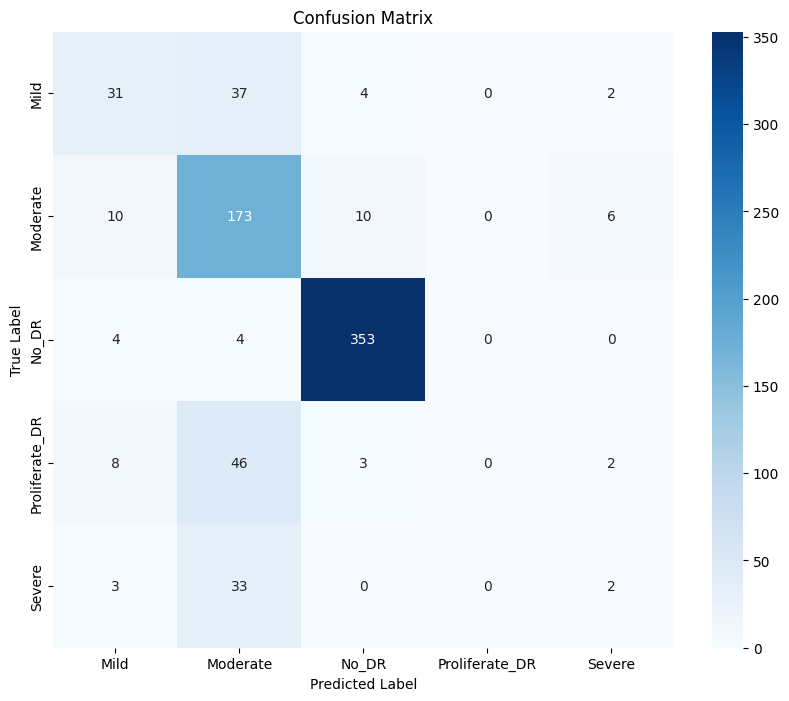

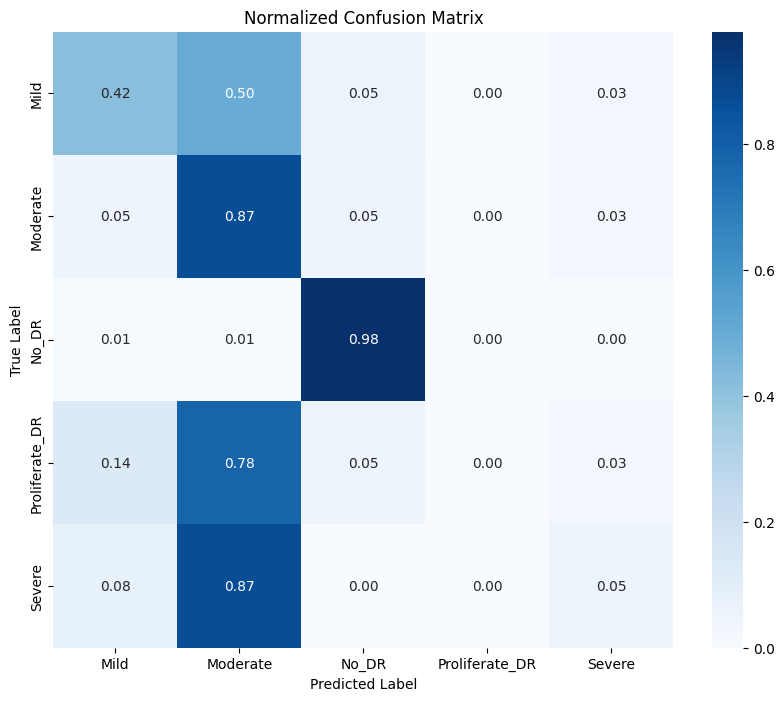

In [30]:
print("\n" + "="*40)
print("CONFUSION MATRIX")
print("="*40)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Raw counts):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Step 14: Per-Class Metrics

In [31]:
print("\n" + "="*40)
print("PER-CLASS METRICS")
print("="*40)
for i, class_name in enumerate(class_names):
    class_precision = precision_recall_fscore_support(y_true, y_pred, labels=[i], average=None)[0][0]
    class_recall = precision_recall_fscore_support(y_true, y_pred, labels=[i], average=None)[1][0]
    class_f1 = precision_recall_fscore_support(y_true, y_pred, labels=[i], average=None)[2][0]
    class_support = precision_recall_fscore_support(y_true, y_pred, labels=[i], average=None)[3][0]

    print(f"{class_name}:")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall: {class_recall:.4f}")
    print(f"  F1-Score: {class_f1:.4f}")
    print(f"  Support: {class_support}")
    print()

#


PER-CLASS METRICS
Mild:
  Precision: 0.5536
  Recall: 0.4189
  F1-Score: 0.4769
  Support: 74

Moderate:
  Precision: 0.5904
  Recall: 0.8693
  F1-Score: 0.7033
  Support: 199

No_DR:
  Precision: 0.9541
  Recall: 0.9778
  F1-Score: 0.9658
  Support: 361

Proliferate_DR:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 59

Severe:
  Precision: 0.1667
  Recall: 0.0526
  F1-Score: 0.0800
  Support: 38



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

## Step 15: Enhanced Prediction Functions

In [32]:
# Basic prediction function
def predict_image(model, image_path, class_indices):
    """
    Make prediction on a single image
    """
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    # Get class name
    class_names = {v: k for k, v in class_indices.items()}
    predicted_class_name = class_names[predicted_class]

    return predicted_class_name, confidence

# Enhanced prediction function with confidence assessment
def enhanced_predict_image(model, image_path, class_indices, threshold=0.8):
    """
    Enhanced prediction function with confidence threshold
    """
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    # Get class name
    class_names = {v: k for k, v in class_indices.items()}
    predicted_class_name = class_names[predicted_class]

    # Confidence assessment
    if confidence < threshold:
        confidence_level = "Low confidence - Consider manual review"
    else:
        confidence_level = "High confidence"

    return predicted_class_name, confidence, confidence_level, prediction[0]



## Step 16: Save Results and Model

In [33]:
# Function to save comprehensive results
def save_evaluation_results(kappa_score, qwk_score, accuracy, precision, recall, f1):
    """
    Save evaluation results to a file
    """
    results = {
        'Accuracy': accuracy,
        'Cohen_Kappa': kappa_score,
        'Quadratic_Weighted_Kappa': qwk_score,
        'Weighted_Precision': precision,
        'Weighted_Recall': recall,
        'Weighted_F1': f1,
        'Kappa_Interpretation': interpret_kappa(kappa_score),
        'QWK_Interpretation': interpret_kappa(qwk_score)
    }

    # Save to CSV
    results_df = pd.DataFrame([results])
    results_df.to_csv('diabetic_retinopathy_evaluation_results.csv', index=False)

    print("Evaluation results saved to 'diabetic_retinopathy_evaluation_results.csv'")

    return results

# Save results
evaluation_results = save_evaluation_results(
    kappa_score, qwk_score, accuracy, precision, recall, f1
)

# Save the model
model.save('diabetic_retinopathy_model.h5')
print("Model saved as 'diabetic_retinopathy_model.h5'")



Evaluation results saved to 'diabetic_retinopathy_evaluation_results.csv'
Model saved as 'diabetic_retinopathy_model.h5'


## Step 17: Final Summary

In [35]:
print("\n" + "="*60)
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Model Performance on Validation Set:")
print(f"  • Accuracy: {accuracy:.4f}")
print(f"  • Cohen's Kappa: {kappa_score:.4f} ({interpret_kappa(kappa_score)})")
print(f"  • Quadratic Weighted Kappa: {qwk_score:.4f} ({interpret_kappa(qwk_score)})")
print(f"  • Weighted F1-Score: {f1:.4f}")
print(f"\nThe Quadratic Weighted Kappa is particularly important for diabetic")
print(f"retinopathy classification as it accounts for the ordinal nature of")
print(f"severity levels and gives partial credit for 'near misses'.")
print("\nModel and results saved successfully!")



FINAL EVALUATION SUMMARY
Model Performance on Validation Set:
  • Accuracy: 0.7647
  • Cohen's Kappa: 0.6279 (Substantial agreement)
  • Quadratic Weighted Kappa: 0.2524 (Fair agreement)
  • Weighted F1-Score: 0.7208

The Quadratic Weighted Kappa is particularly important for diabetic
retinopathy classification as it accounts for the ordinal nature of
severity levels and gives partial credit for 'near misses'.

Model and results saved successfully!


## Step 18: Usage Examples

In [36]:
print("\n" + "="*60)
print("USAGE EXAMPLES")
print("="*60)
print("1. Basic prediction:")
print("   predicted_class, confidence = predict_image(model, 'path/to/image.jpg', train_data.class_indices)")
print("\n2. Enhanced prediction with confidence assessment:")
print("   predicted_class, confidence, confidence_level, all_probs = enhanced_predict_image(model, 'path/to/image.jpg', train_data.class_indices)")
print("\n3. Model is saved as 'diabetic_retinopathy_model.h5'")
print("4. Evaluation results saved as 'diabetic_retinopathy_evaluation_results.csv'")

print("\n" + "="*60)
print("TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*60)


USAGE EXAMPLES
1. Basic prediction:
   predicted_class, confidence = predict_image(model, 'path/to/image.jpg', train_data.class_indices)

2. Enhanced prediction with confidence assessment:
   predicted_class, confidence, confidence_level, all_probs = enhanced_predict_image(model, 'path/to/image.jpg', train_data.class_indices)

3. Model is saved as 'diabetic_retinopathy_model.h5'
4. Evaluation results saved as 'diabetic_retinopathy_evaluation_results.csv'

TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
